In [1]:
import numpy as np

# Load preprocessed bee movement samples
samples_array = np.load('bee_samples.npy')
print("✅ Loaded samples with shape:", samples_array.shape)

✅ Loaded samples with shape: (162770, 30, 4)


## Import PyTorch and Set Up

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

convert the data into pytourch tensors 

In [3]:
# Convert to PyTorch tensor
samples_tensor = torch.tensor(samples_array, dtype=torch.float32)

# Create a dataset and data loader (for batching)
dataset = TensorDataset(samples_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Build the Autoencoder Model

In [4]:
class BeeAutoencoder(nn.Module):
    def __init__(self):
        super(BeeAutoencoder, self).__init__()
        
        # Encoder: (4 features → 16 → 8 → 4)
        self.encoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4)  # This is the "compressed" representation
        )
        
        # Decoder: (4 → 8 → 16 → 4 features)
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
        )

    def forward(self, x):
        # Shape of x: (batch_size, 30, 4)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## training the model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



# Create model, loss function and optimizer
model = BeeAutoencoder()
loss_fn = nn.MSELoss()  # MSE = mean squared error = how different the output is
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch_data = batch[0]  # shape: [128, 30, 4]
        
        # Flatten time dimension to treat each frame independently: (128*30, 4)
        batch_data_flat = batch_data.view(-1, 4)
        
        # Forward pass
        outputs = model(batch_data_flat)
        loss = loss_fn(outputs, batch_data_flat)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")

✅ Epoch 1/10 - Loss: 0.644059
✅ Epoch 2/10 - Loss: 0.517094
✅ Epoch 3/10 - Loss: 0.333829
✅ Epoch 4/10 - Loss: 0.223344
✅ Epoch 5/10 - Loss: 0.179786
✅ Epoch 6/10 - Loss: 0.141694
✅ Epoch 7/10 - Loss: 0.117134
✅ Epoch 8/10 - Loss: 0.097201
✅ Epoch 9/10 - Loss: 0.085227
✅ Epoch 10/10 - Loss: 0.078733


In [7]:
import torch
import torch.nn as nn
import numpy as np

# 1. Load the preprocessed samples
samples_array = np.load('bee_samples.npy')

# 2. Define the same Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(120, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
autoencoder.eval()  # Evaluation mode

# 3. Convert to tensor and flatten (in chunks)
compressed_list = []

batch_size = 10000  # Use small batch to avoid memory error

for i in range(0, len(samples_array), batch_size):
    batch = samples_array[i:i+batch_size]
    batch_tensor = torch.tensor(batch, dtype=torch.float32)
    batch_flat = batch_tensor.view(batch_tensor.size(0), -1)

    with torch.no_grad():
        compressed = autoencoder.encoder(batch_flat)
    
    compressed_list.append(compressed.numpy())

# 4. Combine all compressed arrays
compressed_all = np.vstack(compressed_list)

# 5. Save for later
np.save('bee_compressed.npy', compressed_all)
print("✅ Saved compressed data:", compressed_all.shape)

✅ Saved compressed data: (162770, 4)


## clustering 

In [9]:
# Step 1: Import necessary libraries
from sklearn.cluster import KMeans
import numpy as np

# Step 2: Load the compressed data
compressed_all = np.load('bee_compressed.npy')  # shape: (162770, 4)

# Step 3: Decide how many clusters you want
k = 3  # You can try other numbers like 5, 8, 12

# Step 4: Create and fit the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(compressed_all)

# Step 5: Save the cluster labels if needed
np.save('bee_cluster_labels.npy', cluster_labels)

# Step 6: Check the results
unique, counts = np.unique(cluster_labels, return_counts=True)
print("✅ Cluster sizes:")
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} samples")

✅ Cluster sizes:
Cluster 0: 162748 samples
Cluster 1: 4 samples
Cluster 2: 18 samples


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


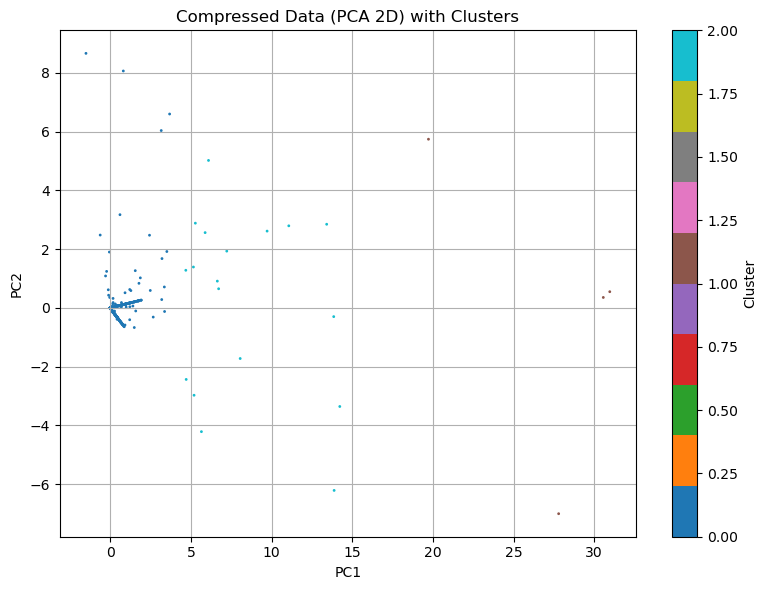

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load compressed data and cluster labels
compressed_all = np.load('bee_compressed.npy')
cluster_labels = np.load('bee_cluster_labels.npy')

# Reduce 4D to 2D using PCA
pca = PCA(n_components=2)
compressed_2d = pca.fit_transform(compressed_all)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(compressed_2d[:, 0], compressed_2d[:, 1], c=cluster_labels, cmap='tab10', s=1)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Compressed Data (PCA 2D) with Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Step 1: Load the saved samples
samples_array = np.load('bee_samples.npy')  # shape: (162770, 30, 4)

# Step 2: Convert to PyTorch tensor and flatten each sample (30, 4) → (120,)
samples_tensor = torch.tensor(samples_array, dtype=torch.float32).view(-1, 120)

# Step 3: Create a DataLoader
dataset = TensorDataset(samples_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Step 4: Define a deeper autoencoder
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(120, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 120)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Step 5: Initialize model, loss function, and optimizer
model = DeepAutoencoder()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the model
losses = []
for epoch in range(1, 21):  # Train for 20 epochs
    total_loss = 0
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch}/20 - Loss: {avg_loss:.6f}")

✅ Epoch 1/20 - Loss: 0.626120
✅ Epoch 2/20 - Loss: 0.563854
✅ Epoch 3/20 - Loss: 0.499883
✅ Epoch 4/20 - Loss: 0.446978
✅ Epoch 5/20 - Loss: 0.415858
✅ Epoch 6/20 - Loss: 0.367023
✅ Epoch 7/20 - Loss: 0.354823
✅ Epoch 8/20 - Loss: 0.423056
✅ Epoch 9/20 - Loss: 0.462592
✅ Epoch 10/20 - Loss: 0.326941
✅ Epoch 11/20 - Loss: 0.261258
✅ Epoch 12/20 - Loss: 0.294753
✅ Epoch 13/20 - Loss: 0.290125
✅ Epoch 14/20 - Loss: 0.262842
✅ Epoch 15/20 - Loss: 0.234824
✅ Epoch 16/20 - Loss: 0.315932
✅ Epoch 17/20 - Loss: 0.262395
✅ Epoch 18/20 - Loss: 0.253601
✅ Epoch 19/20 - Loss: 0.216598
✅ Epoch 20/20 - Loss: 0.273057


In [12]:
# Make sure model is in evaluation mode
model.eval()

compressed_outputs = []

# Go through all samples in batches
with torch.no_grad():
    for batch in DataLoader(dataset, batch_size=10000):
        x = batch[0]
        encoded = model.encoder(x)
        compressed_outputs.append(encoded.numpy())

# Combine and save
compressed_array = np.vstack(compressed_outputs)
np.save('bee_compressed_deep.npy', compressed_array)
print("✅ Compressed data shape:", compressed_array.shape)
print("✅ Saved to 'bee_compressed_deep.npy'")

✅ Compressed data shape: (162770, 4)
✅ Saved to 'bee_compressed_deep.npy'


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


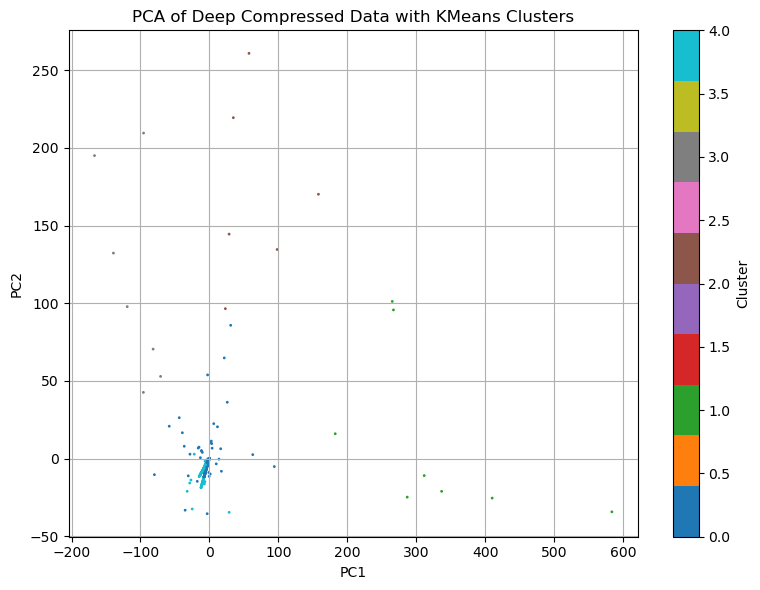

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Load your improved compressed data
compressed_array = np.load('bee_compressed_deep.npy')

# Step 1: Run KMeans clustering
k = 5  # Start with 5 clusters (you can change later)
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(compressed_array)

# Optional: Save cluster labels
np.save('bee_cluster_labels_deep.npy', cluster_labels)

# Step 2: Visualize with PCA (2D)
pca = PCA(n_components=2)
compressed_2d = pca.fit_transform(compressed_array)

plt.figure(figsize=(8, 6))
plt.scatter(compressed_2d[:, 0], compressed_2d[:, 1], c=cluster_labels, cmap='tab10', s=1)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Deep Compressed Data with KMeans Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

# Load the cluster labels
cluster_labels = np.load('bee_cluster_labels_deep.npy')

# Count the number of samples in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)

# Print the result
print("✅ Cluster sizes:")
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} samples")

✅ Cluster sizes:
Cluster 0: 162608 samples
Cluster 1: 8 samples
Cluster 2: 6 samples
Cluster 3: 7 samples
Cluster 4: 141 samples


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


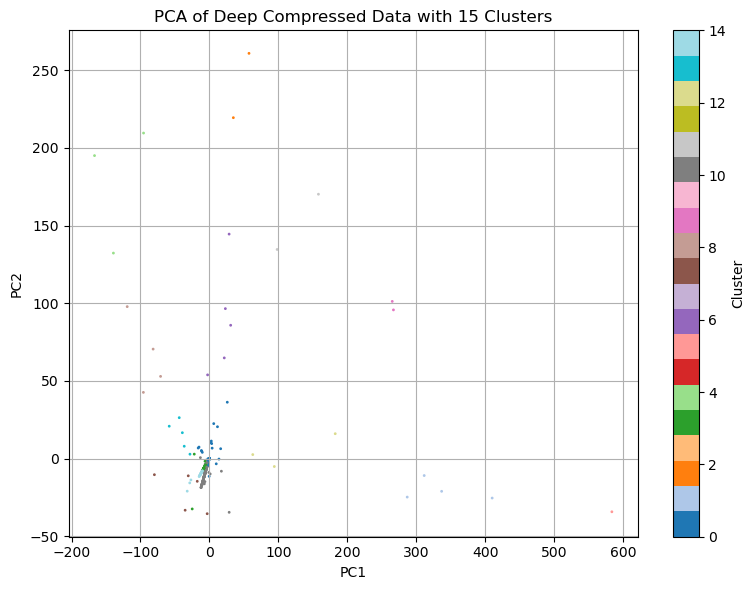

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Load your improved compressed data
compressed_array = np.load('bee_compressed_deep.npy')

# Step 1: Run KMeans clustering with 15 clusters
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(compressed_array)

# Optional: Save cluster labels
np.save('bee_cluster_labels_deep.npy', cluster_labels)

# Step 2: Visualize with PCA (2D)
pca = PCA(n_components=2)
compressed_2d = pca.fit_transform(compressed_array)

plt.figure(figsize=(8, 6))
plt.scatter(compressed_2d[:, 0], compressed_2d[:, 1], c=cluster_labels, cmap='tab20', s=1)
plt.colorbar(label='Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Deep Compressed Data with 15 Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Count how many samples in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
print("✅ Cluster sizes:")
for label, count in zip(unique, counts):
    print(f"Cluster {label}: {count} samples")

✅ Cluster sizes:
Cluster 0: 162500 samples
Cluster 1: 4 samples
Cluster 2: 2 samples
Cluster 3: 74 samples
Cluster 4: 3 samples
Cluster 5: 1 samples
Cluster 6: 5 samples
Cluster 7: 5 samples
Cluster 8: 4 samples
Cluster 9: 2 samples
Cluster 10: 130 samples
Cluster 11: 2 samples
Cluster 12: 3 samples
Cluster 13: 5 samples
Cluster 14: 30 samples


In [17]:
import numpy as np

# Load data
cluster_labels = np.load('bee_cluster_labels_deep.npy')  # shape: (162770,)
samples_array = np.load('bee_samples.npy')               # shape: (162770, 30, 4)

# For tracking: create a mapping list between cluster and sample
cluster_to_sample_map = []

for i, label in enumerate(cluster_labels):
    cluster_to_sample_map.append({
        'index': i,
        'cluster': label,
        'sample': samples_array[i]
    })

# Optional: convert to a pandas DataFrame for easier exploration
import pandas as pd

df_map = pd.DataFrame(cluster_to_sample_map)

# Save to disk if you want to inspect it later
df_map.to_pickle('cluster_sample_mapping.pkl')
print("✅ Mapping saved to 'cluster_sample_mapping.pkl'")

✅ Mapping saved to 'cluster_sample_mapping.pkl'


Cluster 2 has 2 samples


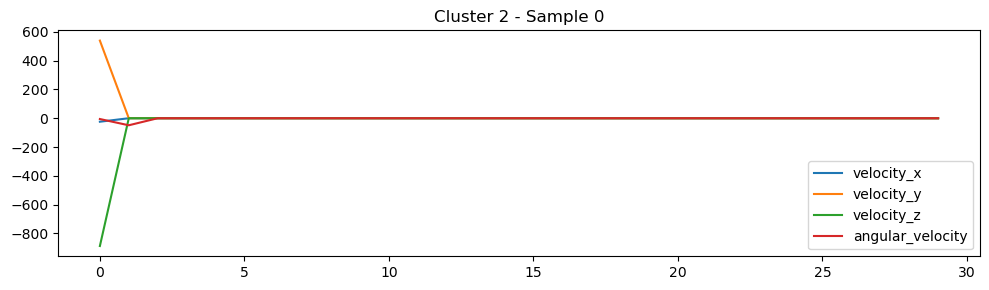

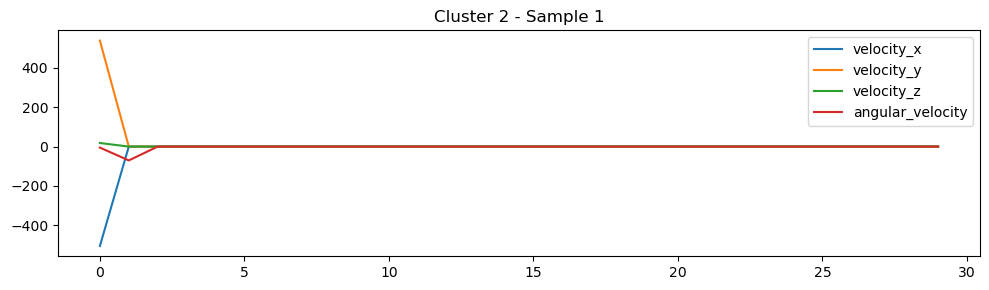

In [19]:
# Load the mapping DataFrame
df_map = pd.read_pickle('cluster_sample_mapping.pkl')

# Pick a cluster to inspect (e.g. cluster 2)
cluster_id = 2
samples_in_cluster = df_map[df_map['cluster'] == cluster_id]

print(f"Cluster {cluster_id} has {len(samples_in_cluster)} samples")

# Plot a few samples
import matplotlib.pyplot as plt

for i in range(min(3, len(samples_in_cluster))):  # Avoid going out of bounds
    sample = samples_in_cluster.iloc[i]['sample']
    
    plt.figure(figsize=(10, 3))
    plt.plot(sample[:, 0], label='velocity_x')
    plt.plot(sample[:, 1], label='velocity_y')
    plt.plot(sample[:, 2], label='velocity_z')
    plt.plot(sample[:, 3], label='angular_velocity')
    plt.title(f'Cluster {cluster_id} - Sample {i}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Cluster 3 has 74 samples


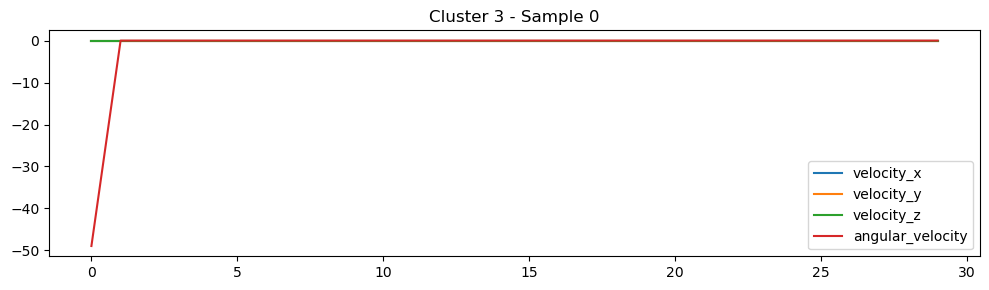

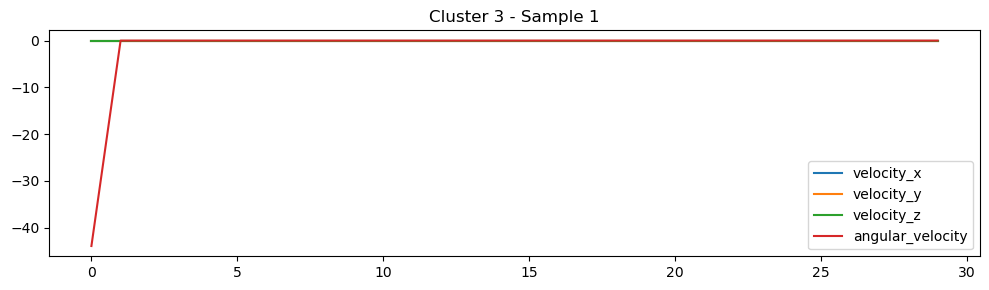

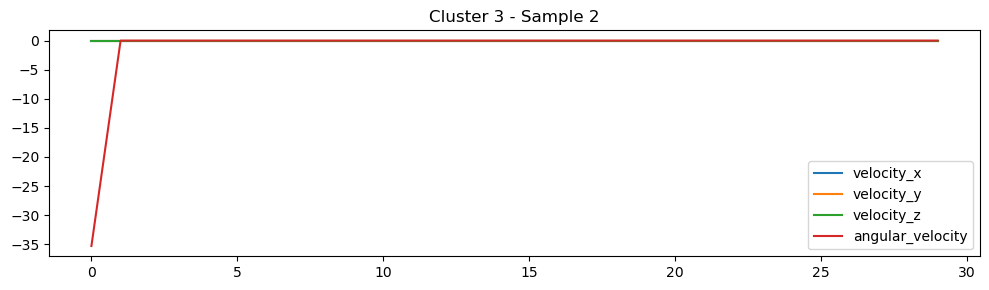

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data again
samples_array = np.load('bee_samples.npy')
cluster_labels = np.load('bee_cluster_labels_deep.npy')

# Create a mapping from cluster → sample
df_map = pd.DataFrame({
    'cluster': cluster_labels,
    'sample': list(samples_array)
})

# Pick a cluster to explore
cluster_id = 3  # 🔁 You can change this to 0, 1, 2...

# Get samples in this cluster
samples_in_cluster = df_map[df_map['cluster'] == cluster_id]

print(f"Cluster {cluster_id} has {len(samples_in_cluster)} samples")

# Show 3 examples
for i in range(min(3, len(samples_in_cluster))):  # Only if enough samples
    sample = samples_in_cluster.iloc[i]['sample']
    
    plt.figure(figsize=(10, 3))
    plt.plot(sample[:, 0], label='velocity_x')
    plt.plot(sample[:, 1], label='velocity_y')
    plt.plot(sample[:, 2], label='velocity_z')
    plt.plot(sample[:, 3], label='angular_velocity')
    plt.title(f'Cluster {cluster_id} - Sample {i}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Cluster 4 has 3 samples


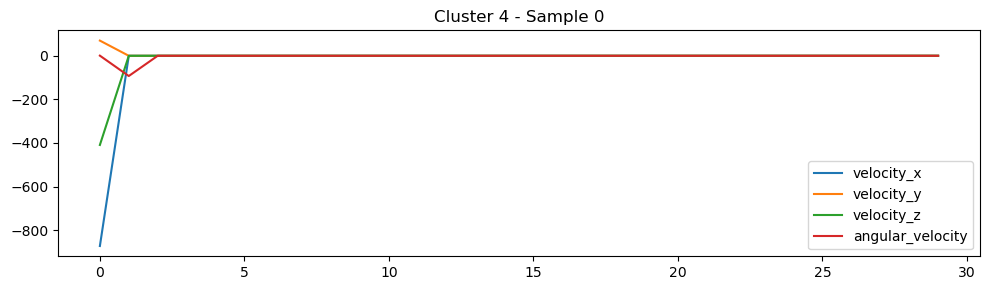

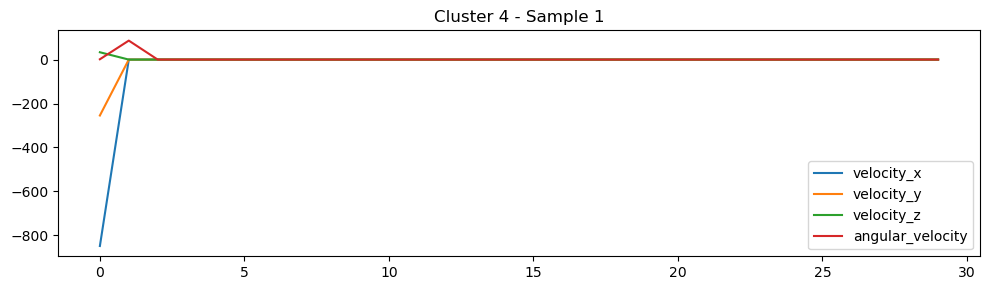

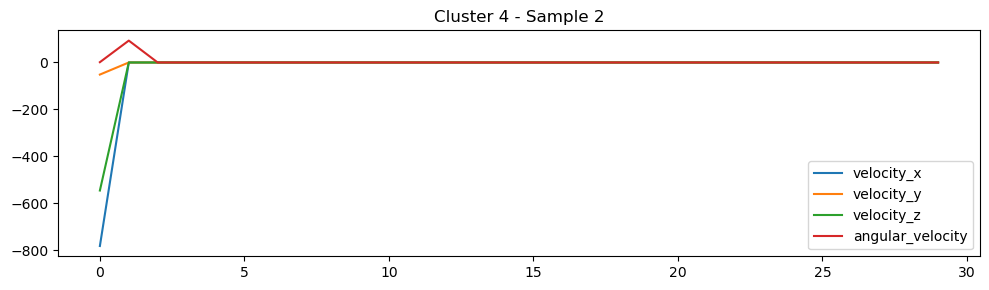

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your data again
samples_array = np.load('bee_samples.npy')
cluster_labels = np.load('bee_cluster_labels_deep.npy')

# Create a mapping from cluster → sample
df_map = pd.DataFrame({
    'cluster': cluster_labels,
    'sample': list(samples_array)
})

# Pick a cluster to explore
cluster_id = 4  # 🔁 You can change this to 0, 1, 2...

# Get samples in this cluster
samples_in_cluster = df_map[df_map['cluster'] == cluster_id]

print(f"Cluster {cluster_id} has {len(samples_in_cluster)} samples")

# Show 3 examples
for i in range(min(3, len(samples_in_cluster))):  # Only if enough samples
    sample = samples_in_cluster.iloc[i]['sample']
    
    plt.figure(figsize=(10, 3))
    plt.plot(sample[:, 0], label='velocity_x')
    plt.plot(sample[:, 1], label='velocity_y')
    plt.plot(sample[:, 2], label='velocity_z')
    plt.plot(sample[:, 3], label='angular_velocity')
    plt.title(f'Cluster {cluster_id} - Sample {i}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [24]:
import numpy as np

# Load your saved cluster labels
cluster_labels = np.load('bee_cluster_labels_deep.npy')

# Find how many unique cluster labels exist
num_clusters = len(np.unique(cluster_labels))
print(f"✅ You have {num_clusters} clusters")

✅ You have 15 clusters



📦 Cluster 0 - 162500 samples


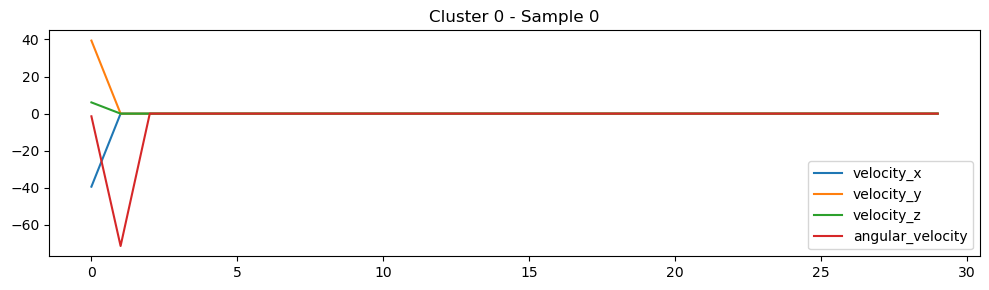

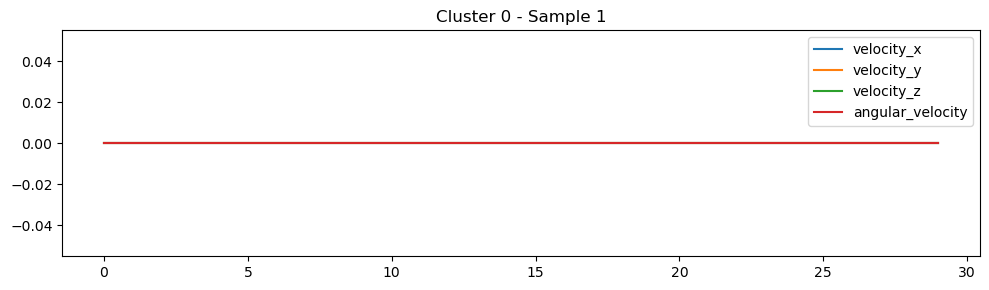

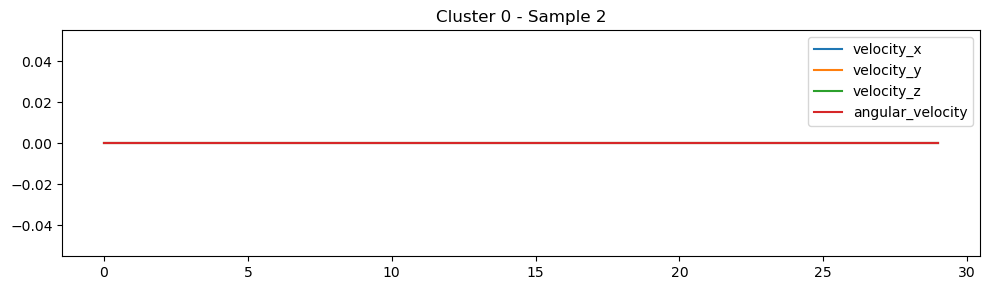


📦 Cluster 1 - 4 samples


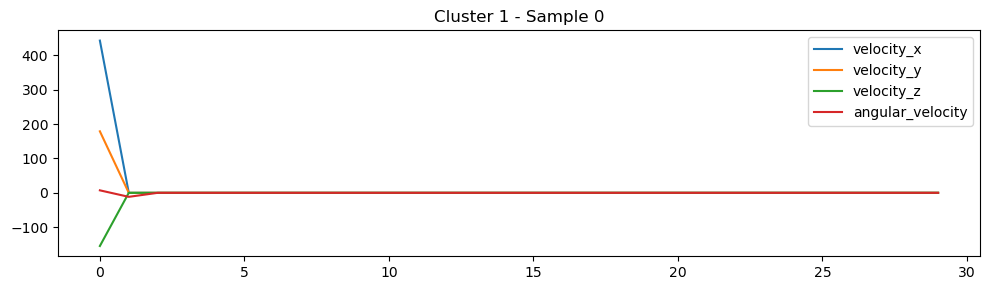

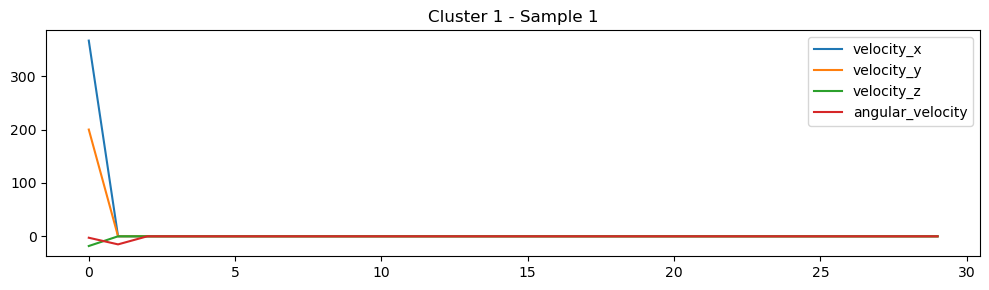

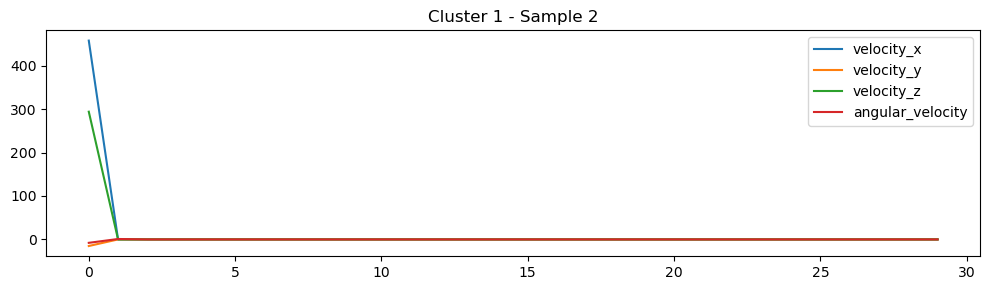


📦 Cluster 2 - 2 samples


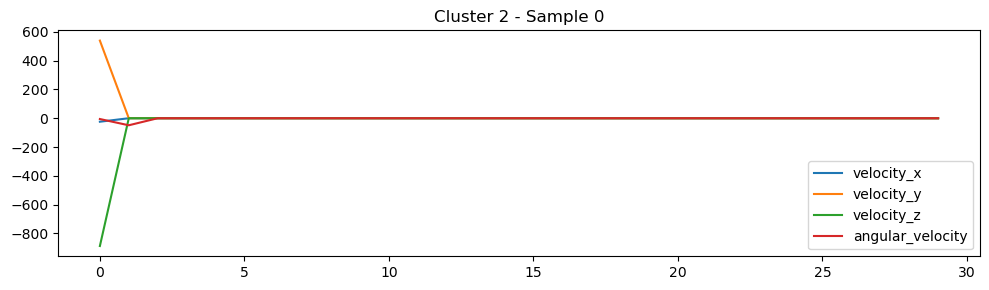

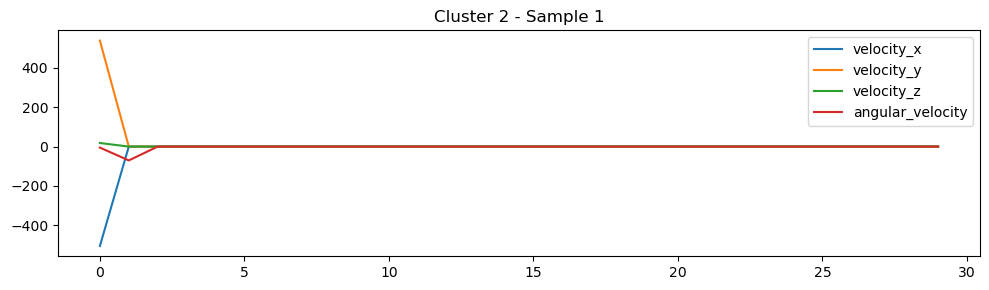


📦 Cluster 3 - 74 samples


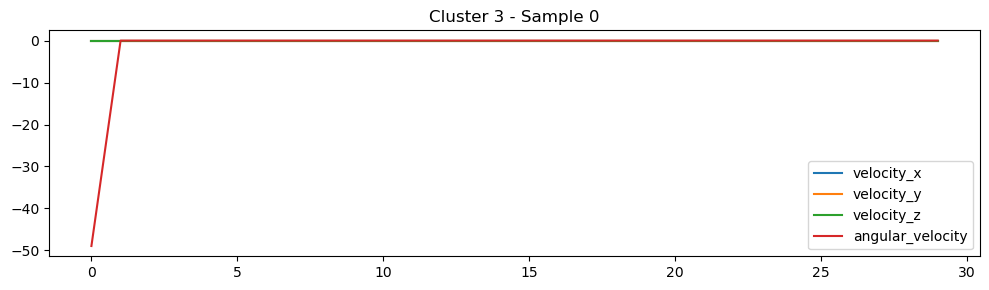

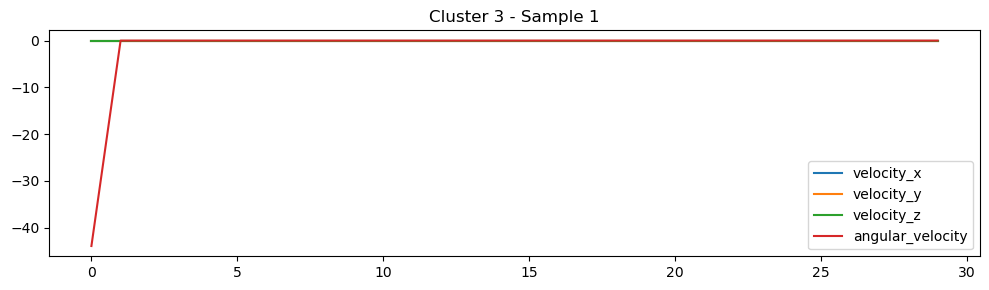

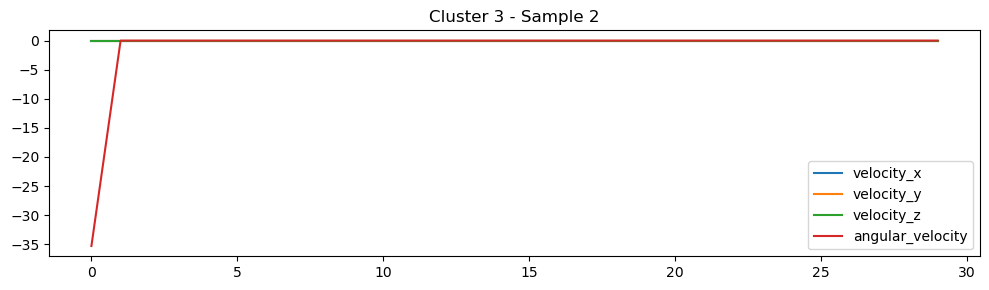


📦 Cluster 4 - 3 samples


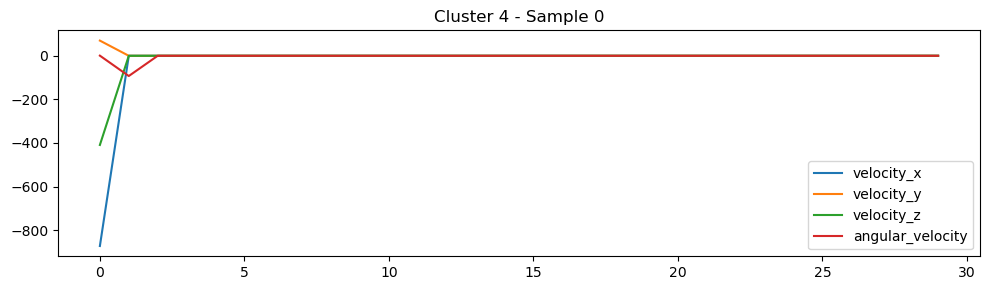

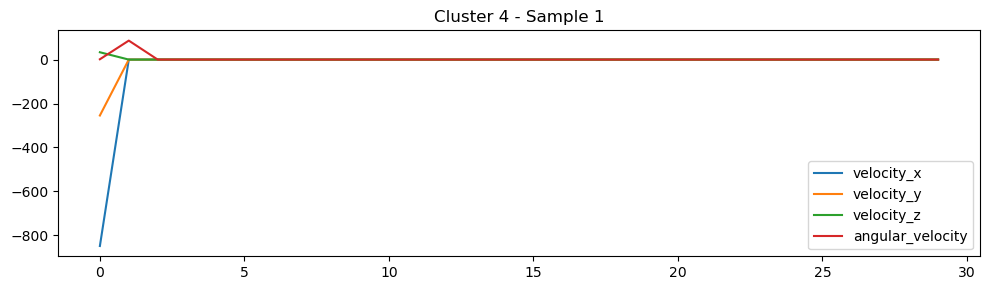

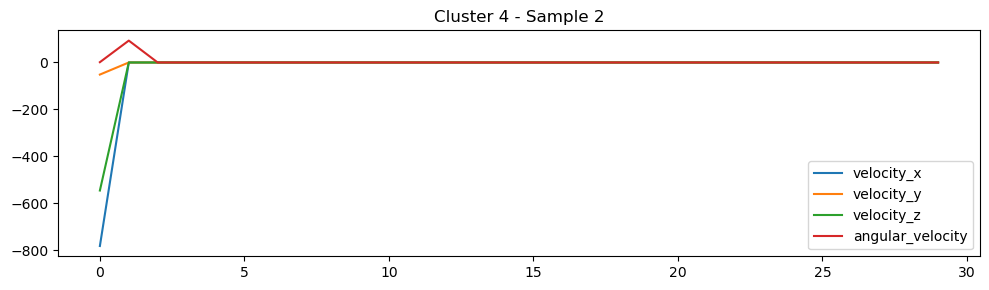


📦 Cluster 5 - 1 samples


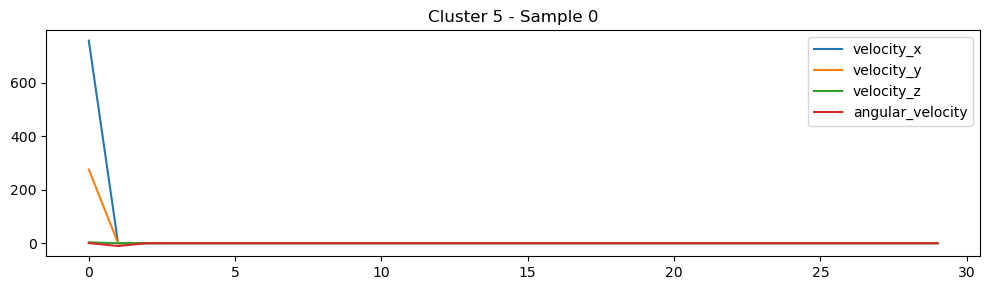


📦 Cluster 6 - 5 samples


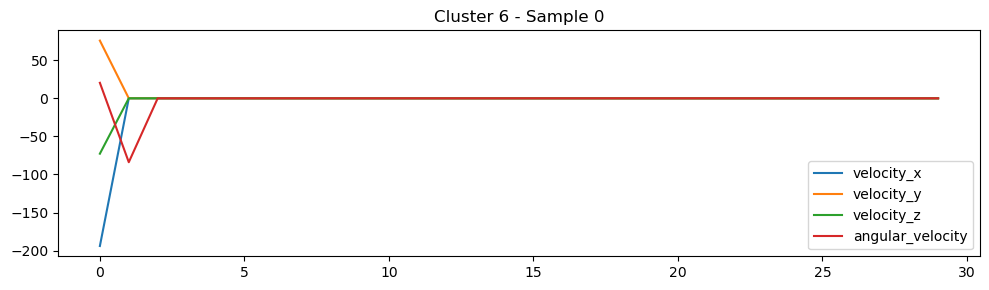

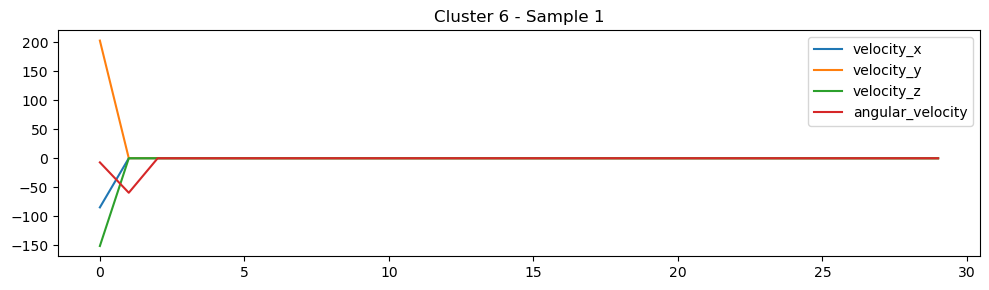

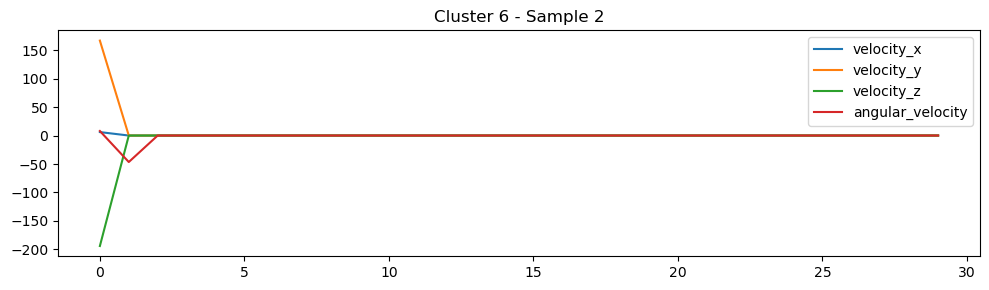


📦 Cluster 7 - 5 samples


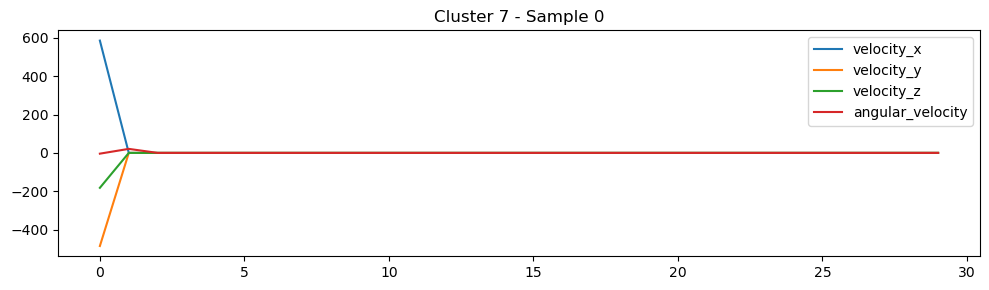

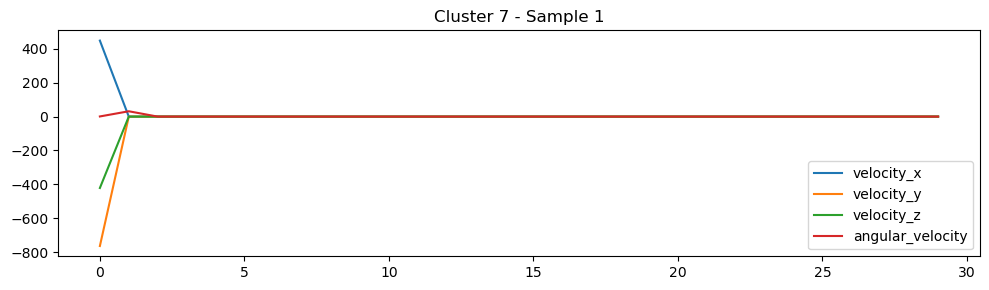

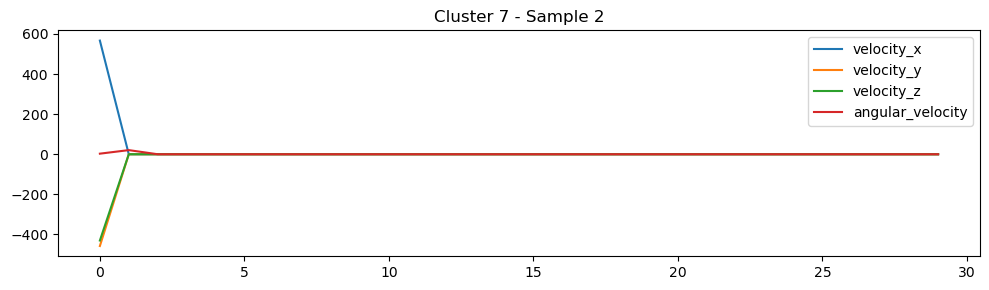


📦 Cluster 8 - 4 samples


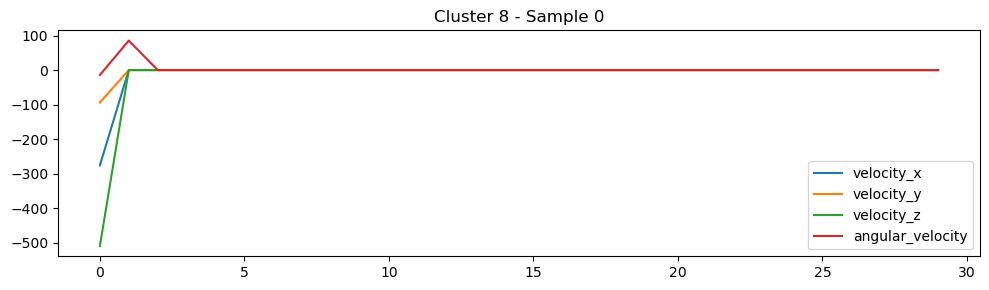

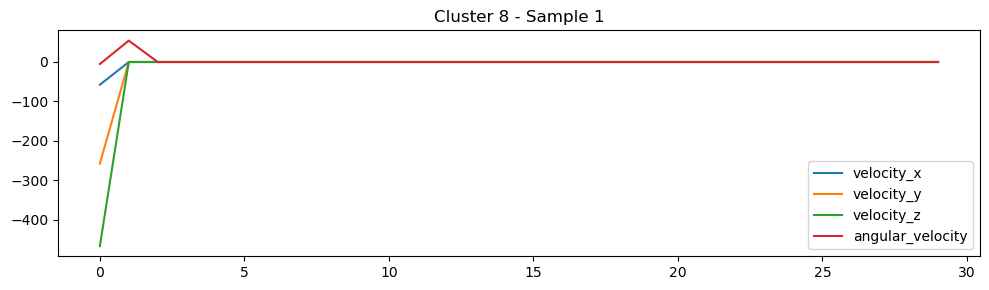

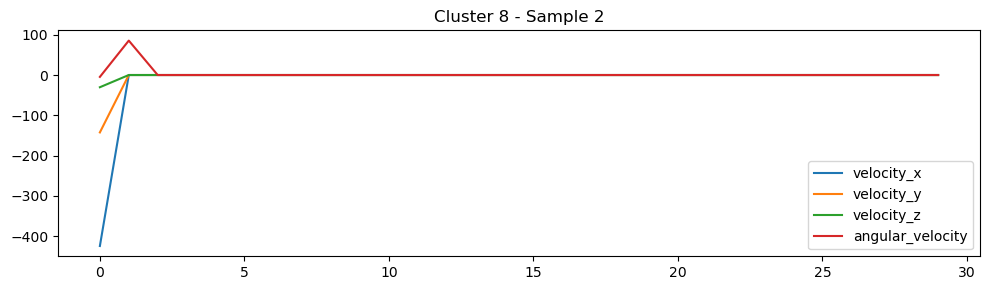


📦 Cluster 9 - 2 samples


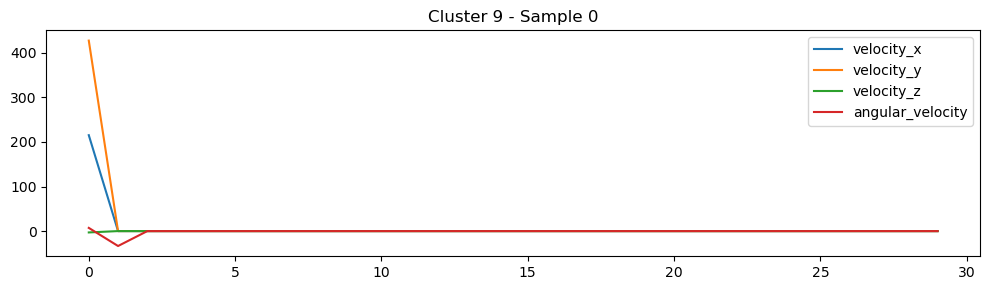

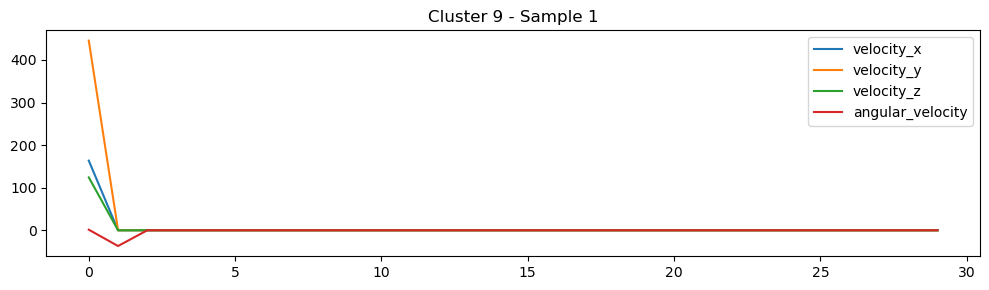


📦 Cluster 10 - 130 samples


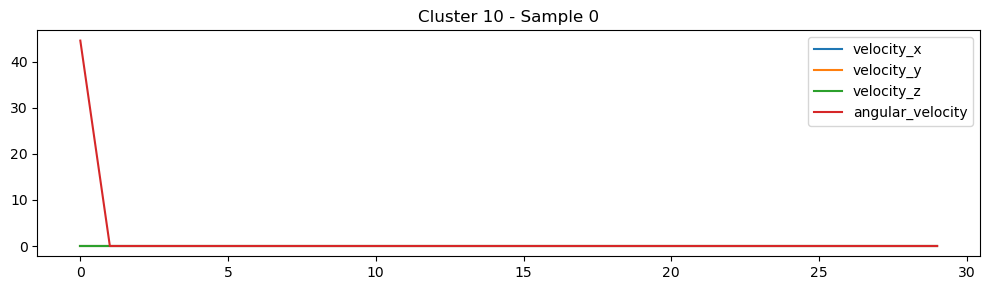

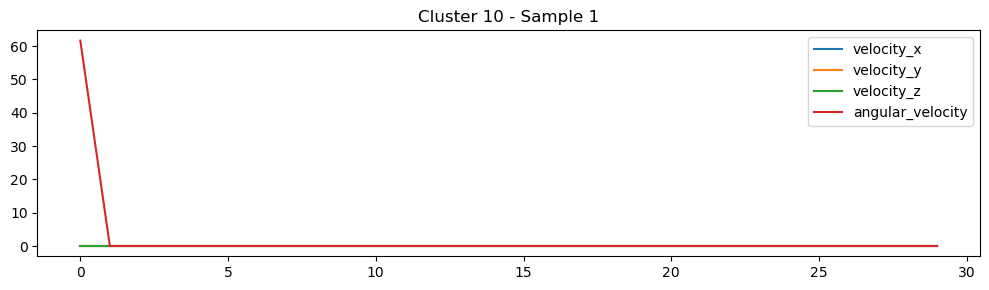

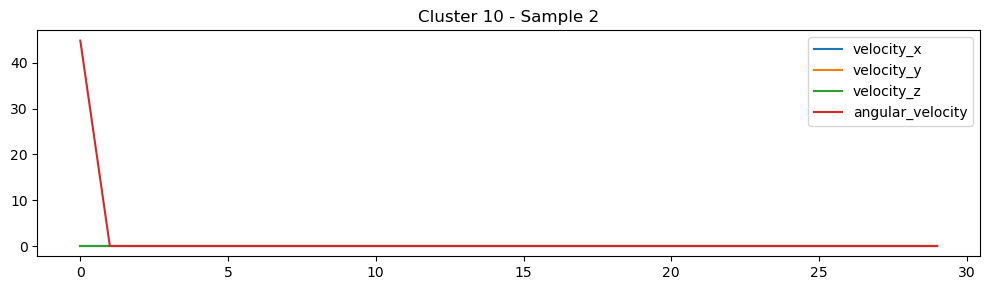


📦 Cluster 11 - 2 samples


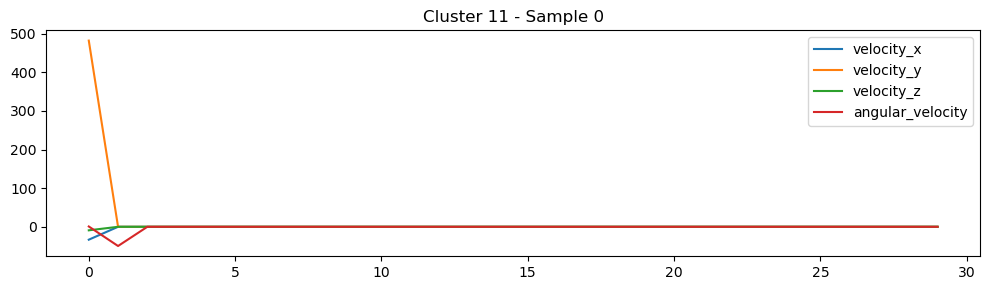

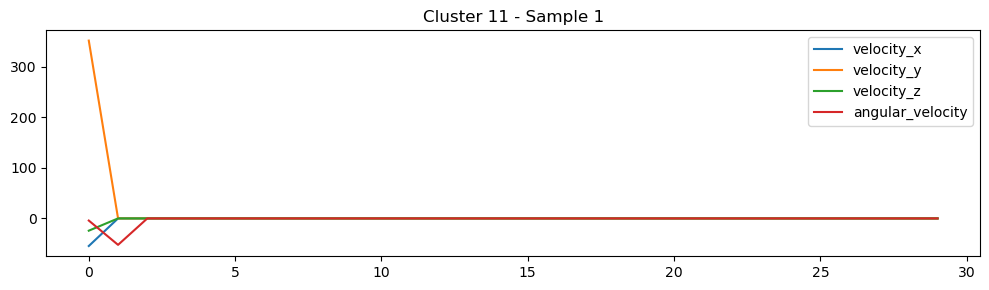


📦 Cluster 12 - 3 samples


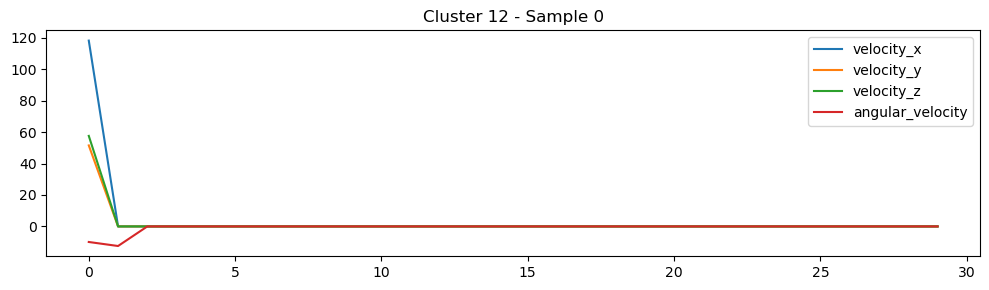

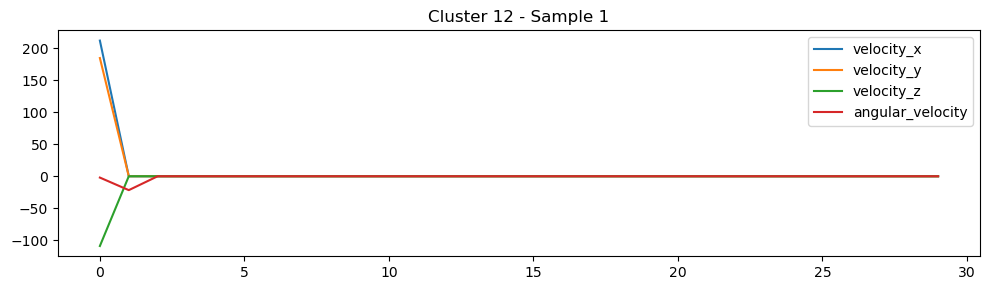

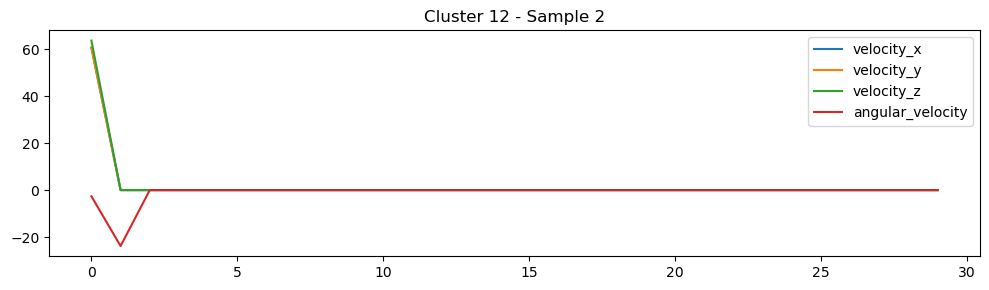


📦 Cluster 13 - 5 samples


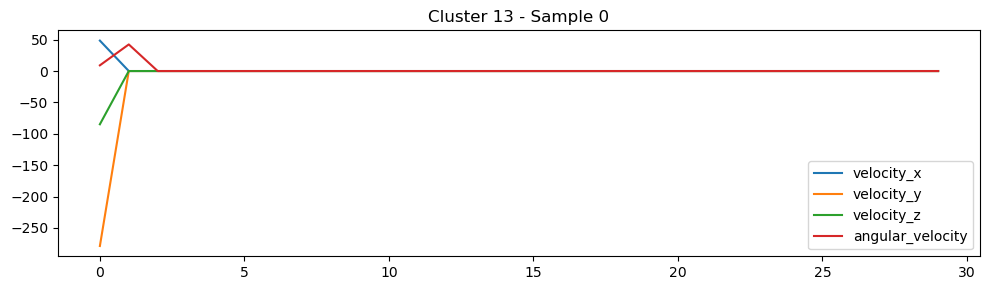

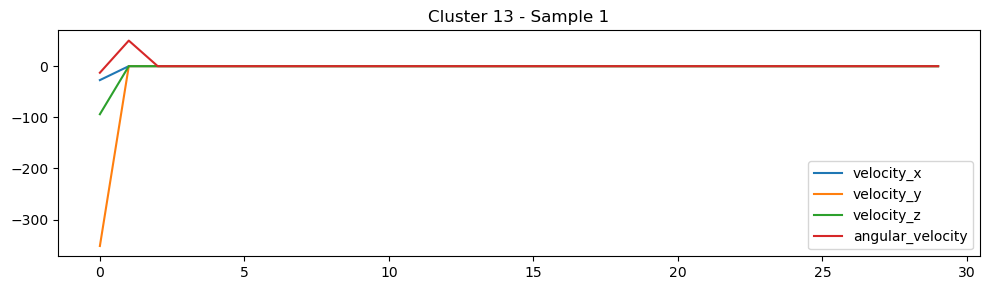

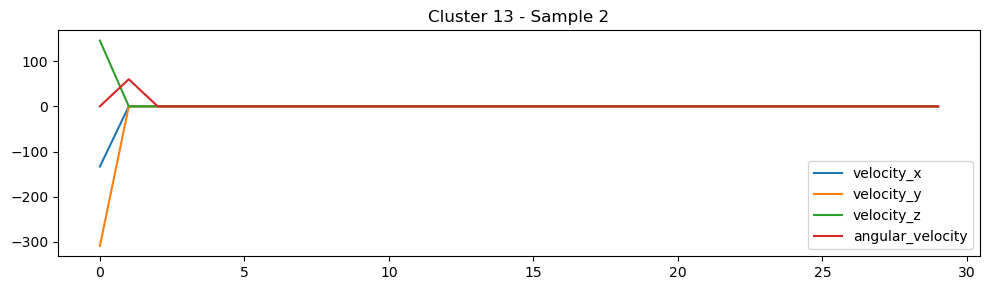


📦 Cluster 14 - 30 samples


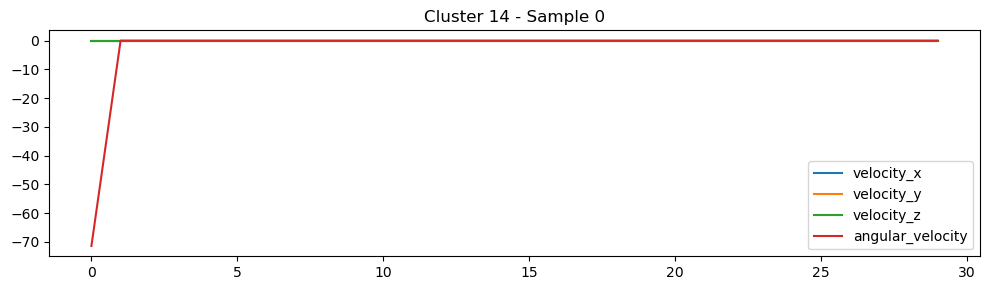

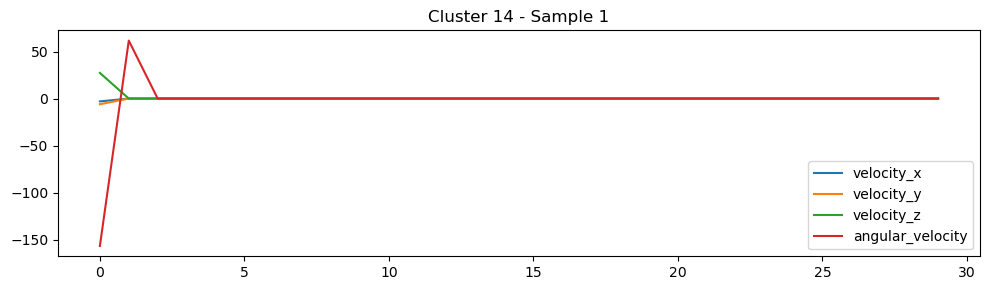

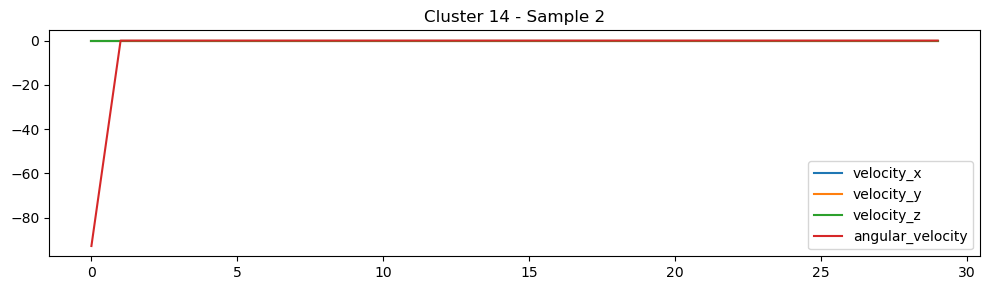

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data
df_map = pd.read_pickle('cluster_sample_mapping.pkl')

# Get the number of clusters (should be 15)
num_clusters = df_map['cluster'].nunique()

# Loop through each cluster
for cluster_id in range(num_clusters):
    samples_in_cluster = df_map[df_map['cluster'] == cluster_id]
    sample_count = len(samples_in_cluster)
    
    print(f"\n📦 Cluster {cluster_id} - {sample_count} samples")

    # Show up to 3 samples from this cluster
    for i in range(min(3, sample_count)):
        sample = samples_in_cluster.iloc[i]['sample']
        
        plt.figure(figsize=(10, 3))
        plt.plot(sample[:, 0], label='velocity_x')
        plt.plot(sample[:, 1], label='velocity_y')
        plt.plot(sample[:, 2], label='velocity_z')
        plt.plot(sample[:, 3], label='angular_velocity')
        plt.title(f'Cluster {cluster_id} - Sample {i}')
        plt.legend()
        plt.tight_layout()
        plt.show()

## give some simple names to each cluster 

<table style="font-family: Arial, sans-serif; font-size: 14px; border-collapse: collapse; width: 100%;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px;">Cluster</th>
      <th style="border: 1px solid #ddd; padding: 8px;">Suggested Name</th>
      <th style="border: 1px solid #ddd; padding: 8px;">Reason</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>0</td><td>Still or No Movement</td><td>Mostly zero values, flat lines — the bee didn’t move.</td></tr>
    <tr><td>1</td><td>Fast Sharp Start</td><td>High velocities at the beginning, then flat — a quick movement start.</td></tr>
    <tr><td>2</td><td>Vertical Burst Down</td><td>Strong negative vertical movement (like falling).</td></tr>
    <tr><td>3</td><td>Minor Turn</td><td>Slight angular velocity only — turning slowly or adjusting.</td></tr>
    <tr><td>4</td><td>Quick Drop and Rest</td><td>Strong drop (negative velocity), then rest — maybe landed quickly.</td></tr>
    <tr><td>5</td><td>Sharp Horizontal Move</td><td>High horizontal velocity — sudden lateral motion.</td></tr>
    <tr><td>6</td><td>Short Zigzag</td><td>Mixed sharp velocity and angular velocity — quick change in direction.</td></tr>
    <tr><td>7</td><td>Lift and Turn</td><td>Combination of upward velocity and angular motion.</td></tr>
    <tr><td>8</td><td>Mild Turn Downward</td><td>Small velocities and moderate angular movement.</td></tr>
    <tr><td>9</td><td>Upward Dart</td><td>Sudden upward motion (positive velocity_y).</td></tr>
    <tr><td>10</td><td>Rotation Only</td><td>Only angular velocity changes — spinning/turning in place.</td></tr>
    <tr><td>11</td><td>Side Hop</td><td>Short horizontal and vertical motion, some rotation.</td></tr>
    <tr><td>12</td><td>Low Speed Wander</td><td>Small movements in all directions.</td></tr>
    <tr><td>13</td><td>Sudden Direction Flip</td><td>Sharp reversal in velocities — maybe turned fast.</td></tr>
    <tr><td>14</td><td>Very Slow Turn</td><td>Slight angular motion, almost no velocity — soft rotation.</td></tr>
  </tbody>
</table>

    Cluster   Count         Suggested Name
0         0  162500   Still or No Movement
1        10     130          Rotation Only
2         3      74             Minor Turn
3        14      30         Very Slow Turn
4         6       5           Short Zigzag
5         7       5          Lift and Turn
6        13       5  Sudden Direction Flip
7         1       4       Fast Sharp Start
8         8       4     Mild Turn Downward
9         4       3    Quick Drop and Rest
10       12       3       Low Speed Wander
11        2       2    Vertical Burst Down
12        9       2            Upward Dart
13       11       2               Side Hop
14        5       1  Sharp Horizontal Move


/var/folders/r3/v38lj7_j5m94834t1g4z9wv80000gn/T/ipykernel_50738/1228370478.py:50: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


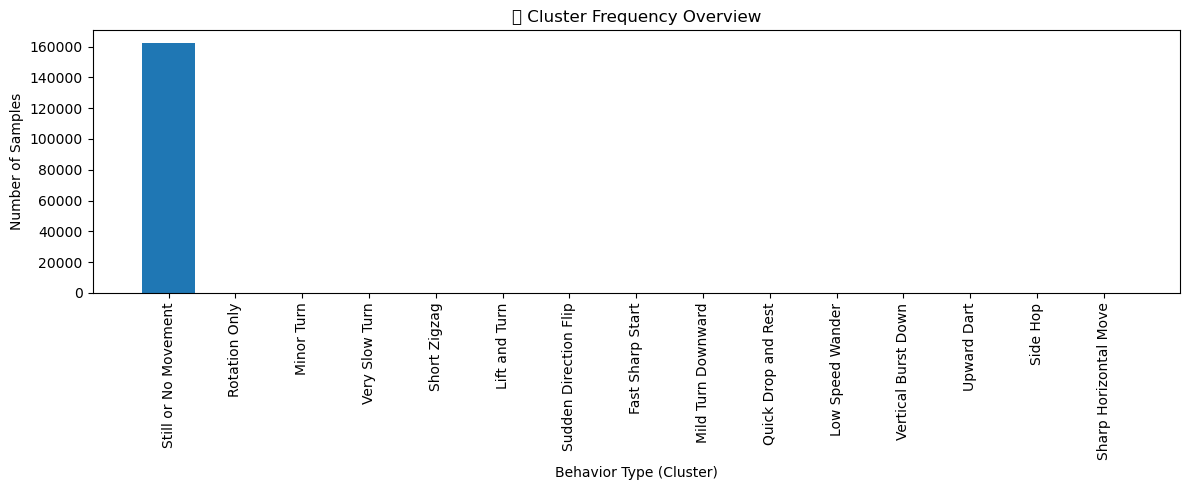

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load cluster labels
cluster_labels = np.load('bee_cluster_labels_deep.npy')

# Count samples in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)

# Suggested names (same as your markdown table)
suggested_names = [
    "Still or No Movement",
    "Fast Sharp Start",
    "Vertical Burst Down",
    "Minor Turn",
    "Quick Drop and Rest",
    "Sharp Horizontal Move",
    "Short Zigzag",
    "Lift and Turn",
    "Mild Turn Downward",
    "Upward Dart",
    "Rotation Only",
    "Side Hop",
    "Low Speed Wander",
    "Sudden Direction Flip",
    "Very Slow Turn"
]

# Create a DataFrame to summarize
cluster_summary = pd.DataFrame({
    'Cluster': unique,
    'Count': counts,
    'Suggested Name': [suggested_names[i] for i in unique]
})

# Sort by count
cluster_summary = cluster_summary.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Print the summary table
print(cluster_summary)

# Plot the bar chart
plt.figure(figsize=(12, 5))
plt.bar(cluster_summary['Suggested Name'], cluster_summary['Count'])
plt.xticks(rotation=90)
plt.xlabel("Behavior Type (Cluster)")
plt.ylabel("Number of Samples")
plt.title("📊 Cluster Frequency Overview")
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
import pandas as pd

# Load your data
cluster_labels = np.load('bee_cluster_labels_deep.npy')  # shape: (162770,)
samples_array = np.load('bee_samples.npy')               # shape: (162770, 30, 4)

# Filter: keep only samples where cluster is NOT 0
active_indices = cluster_labels != 0
filtered_samples = samples_array[active_indices]
filtered_labels = cluster_labels[active_indices]

# Optional: check how many are left
print("✅ Filtered samples shape:", filtered_samples.shape)
print("✅ Unique active clusters:", np.unique(filtered_labels))

✅ Filtered samples shape: (270, 30, 4)
✅ Unique active clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [29]:
# Save for later use
np.save('bee_samples_active_only.npy', filtered_samples)
np.save('bee_cluster_labels_active_only.npy', filtered_labels)
print("✅ Saved filtered samples and labels")

✅ Saved filtered samples and labels


📌 Cluster 1 - 4 samples


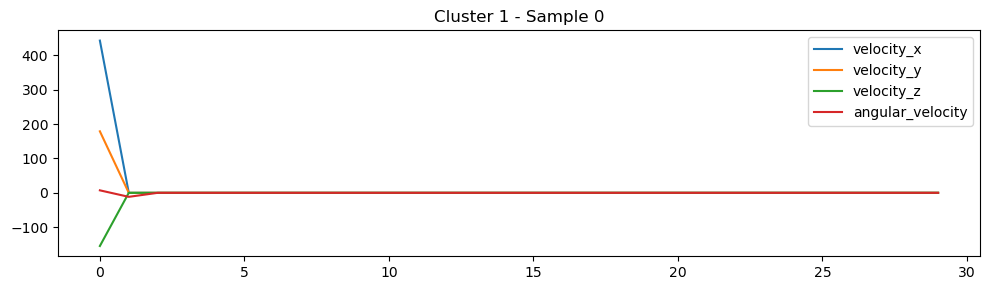

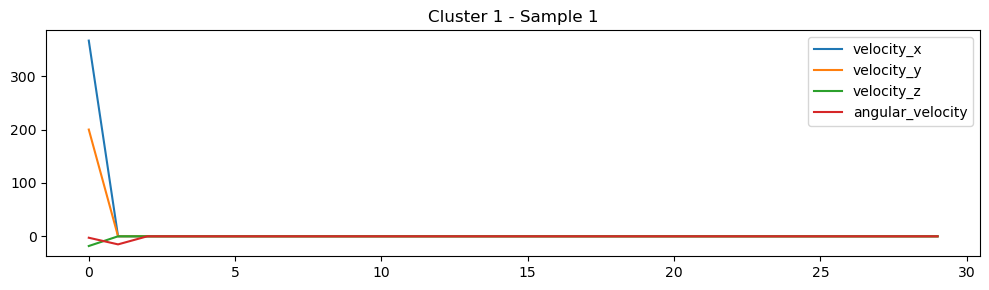

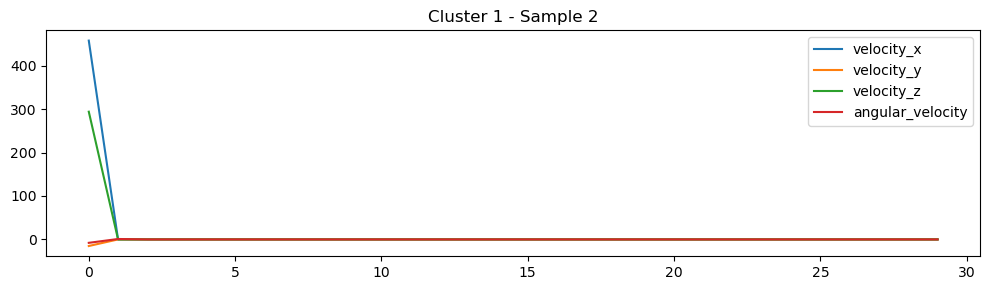

📌 Cluster 2 - 2 samples


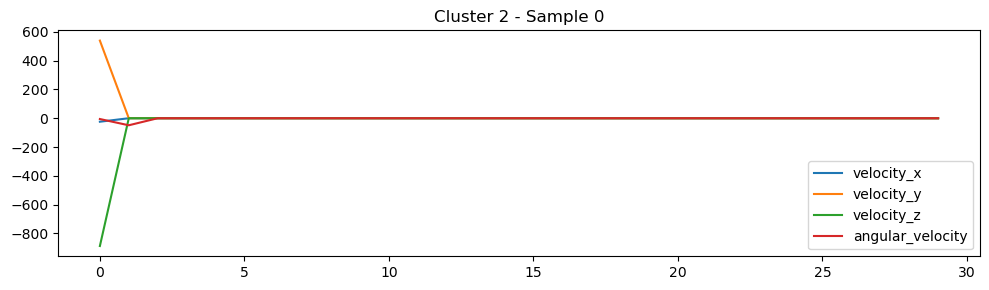

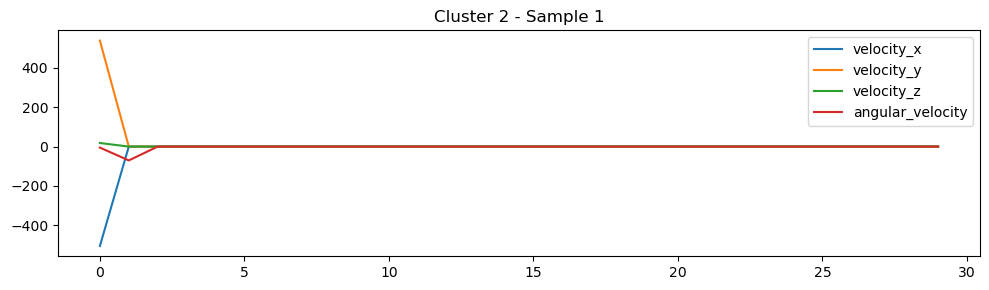

📌 Cluster 3 - 74 samples


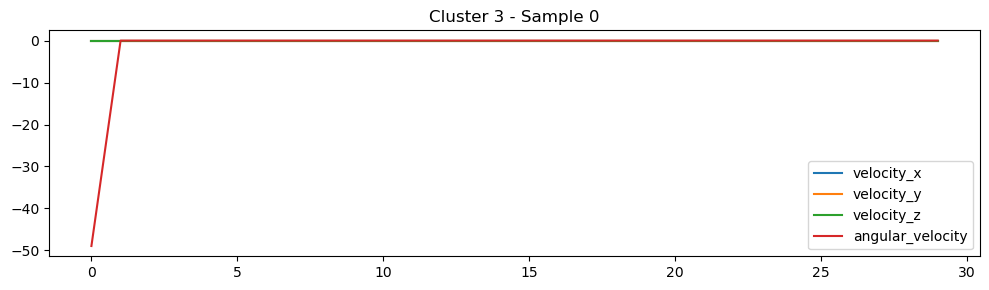

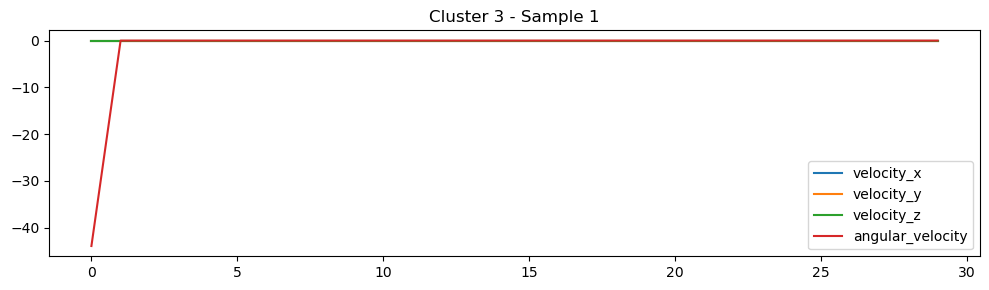

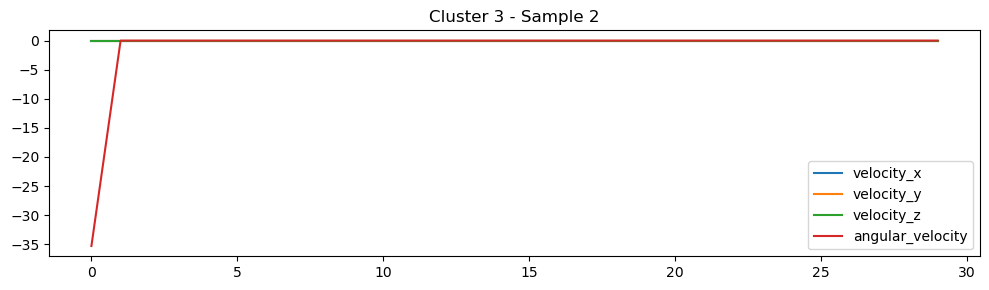

📌 Cluster 4 - 3 samples


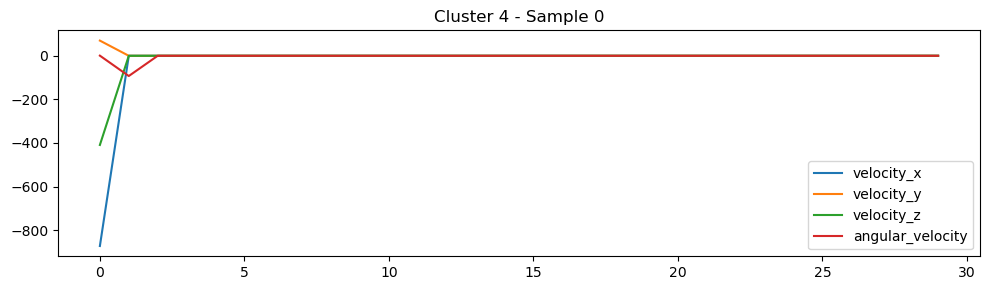

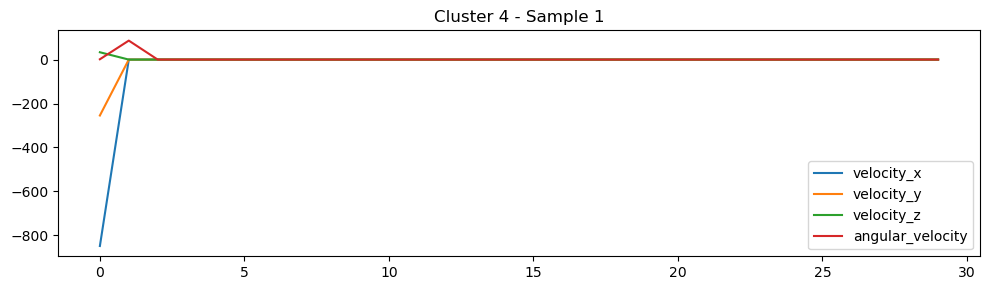

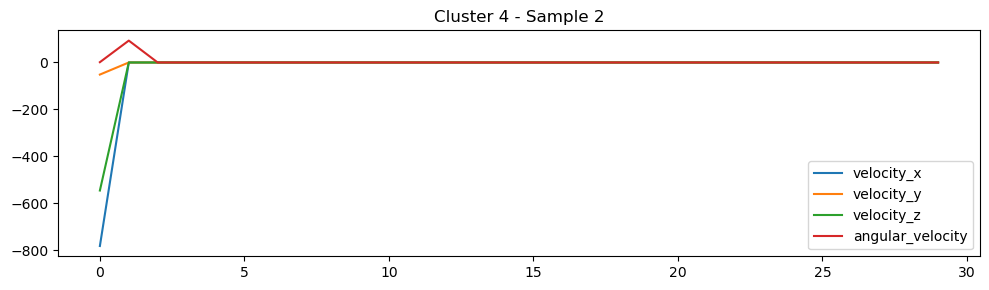

📌 Cluster 5 - 1 samples


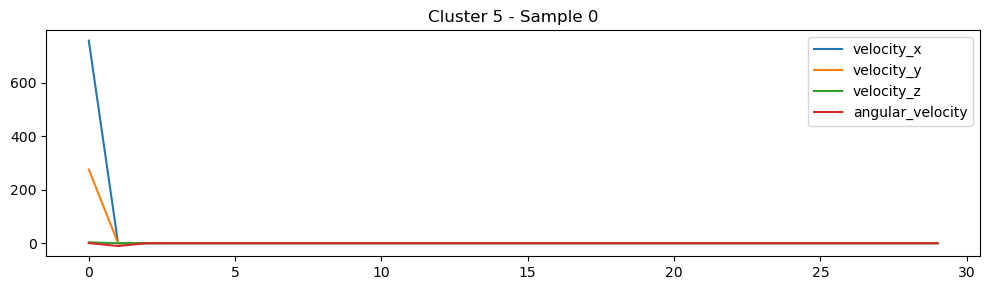

📌 Cluster 6 - 5 samples


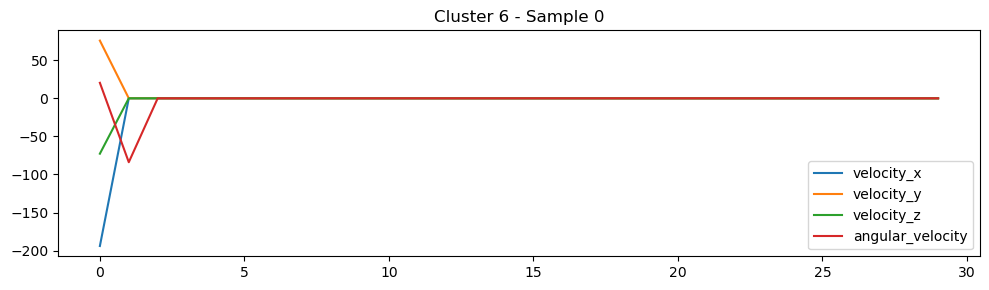

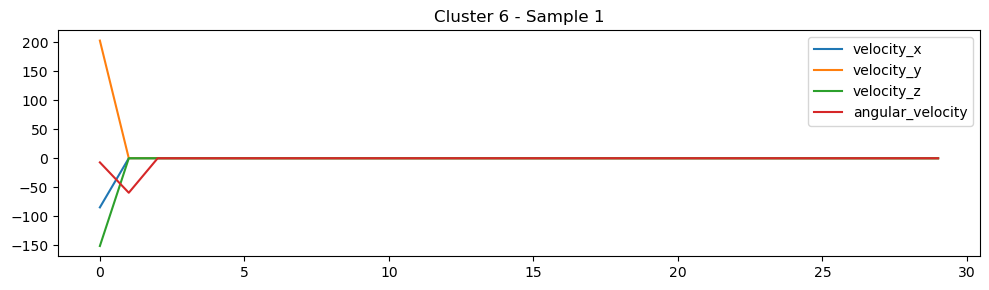

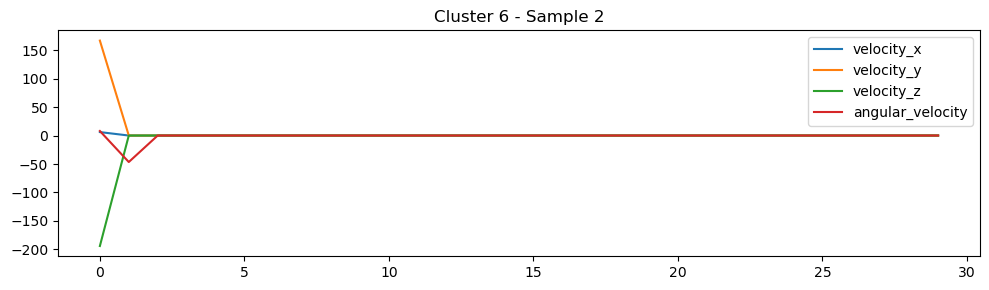

📌 Cluster 7 - 5 samples


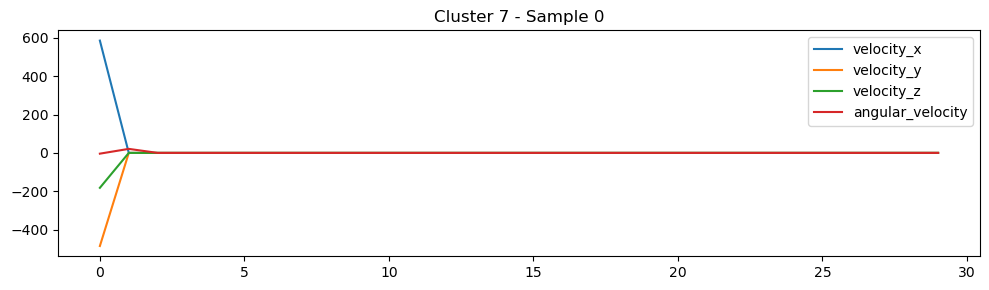

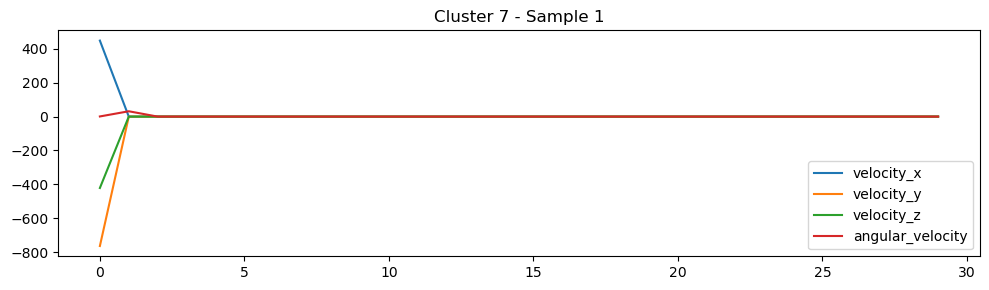

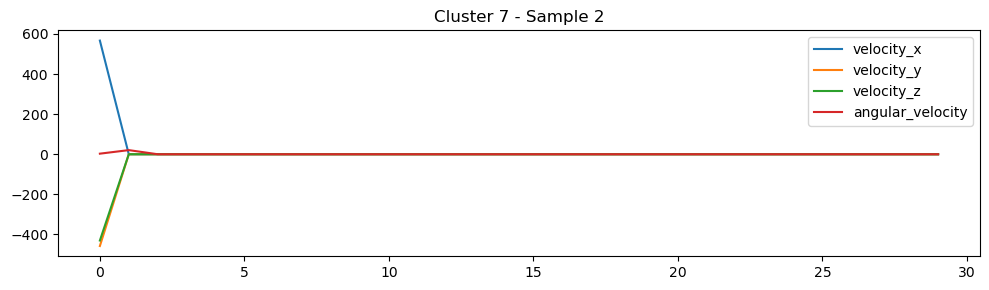

📌 Cluster 8 - 4 samples


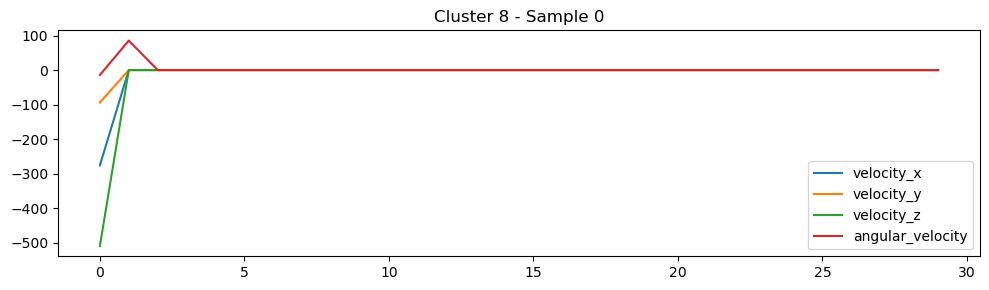

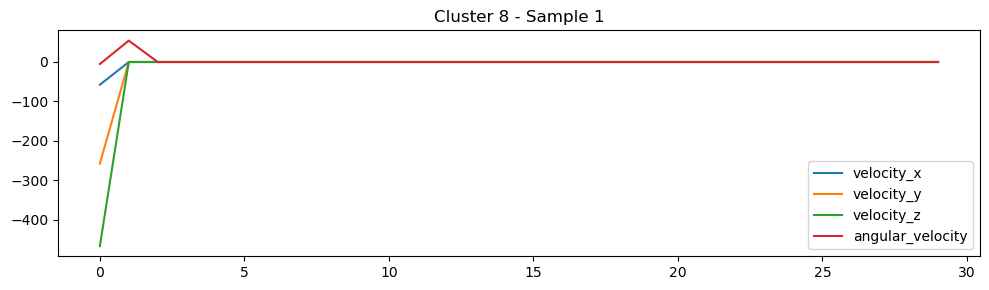

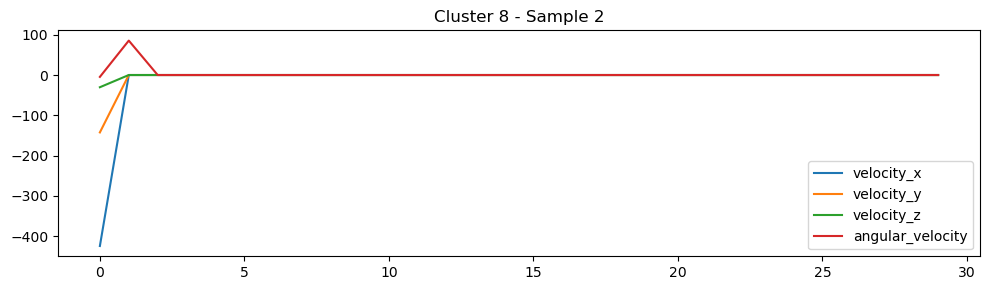

📌 Cluster 9 - 2 samples


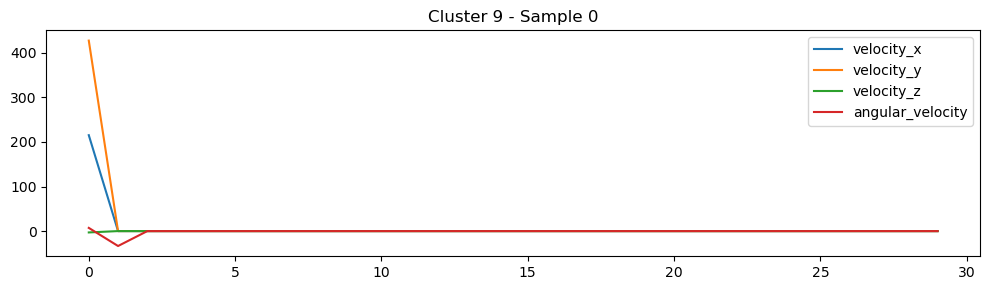

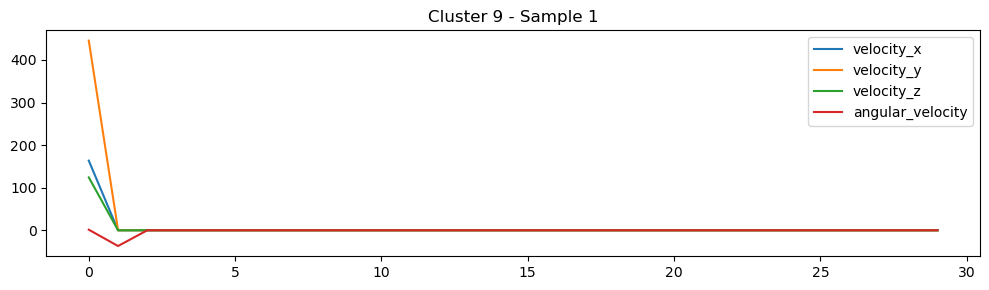

📌 Cluster 10 - 130 samples


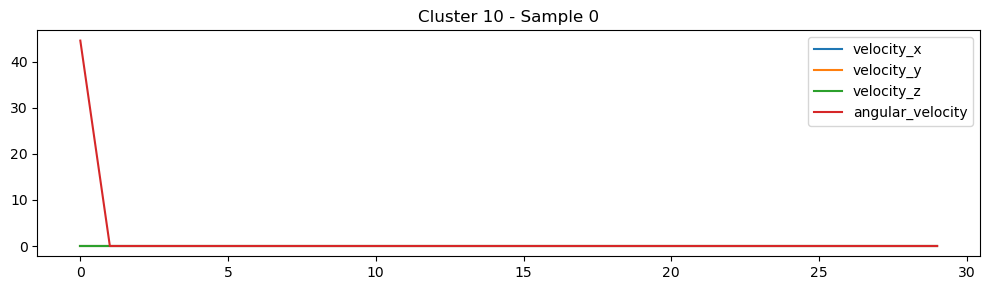

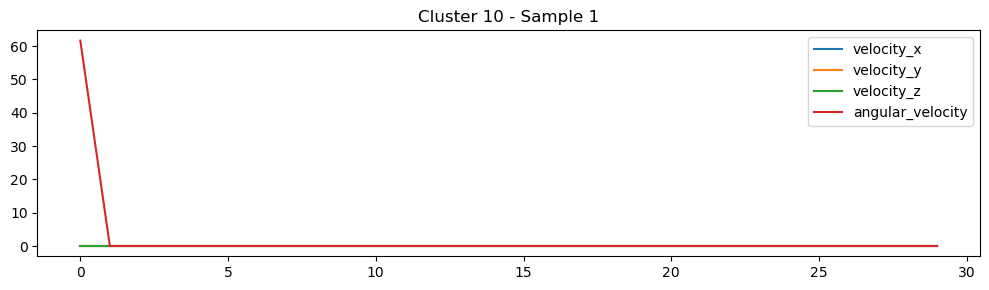

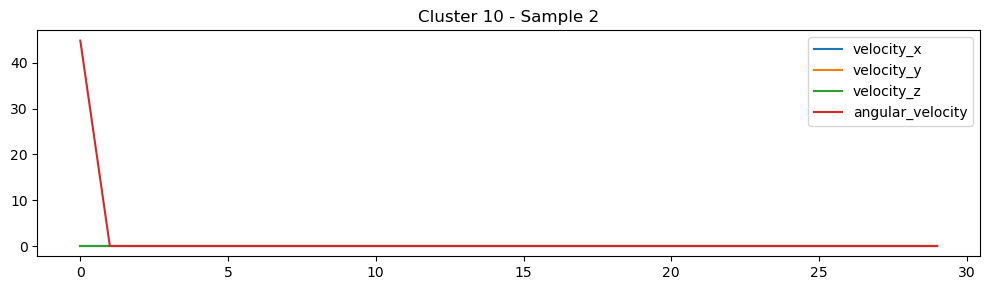

📌 Cluster 11 - 2 samples


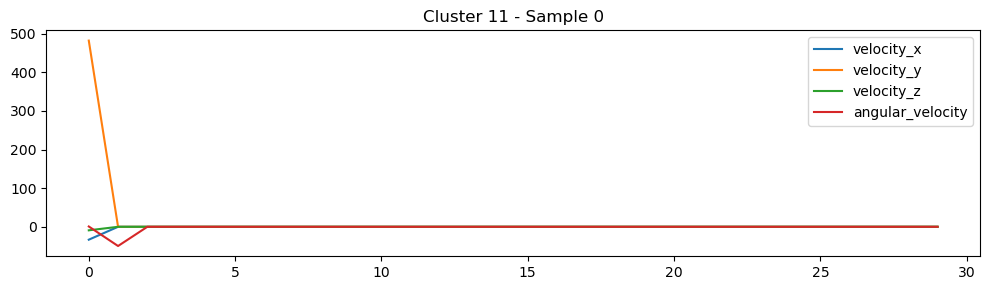

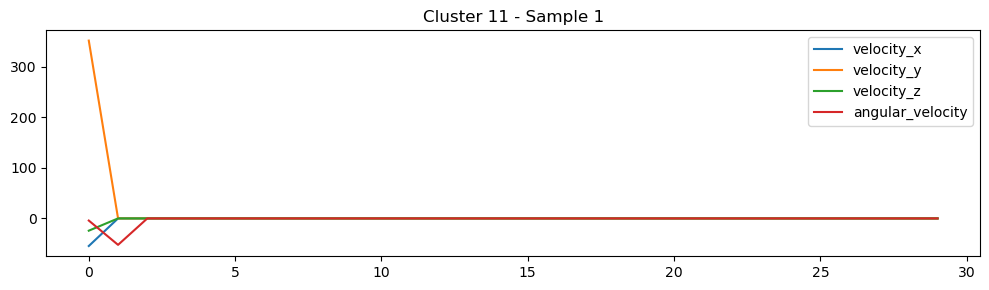

📌 Cluster 12 - 3 samples


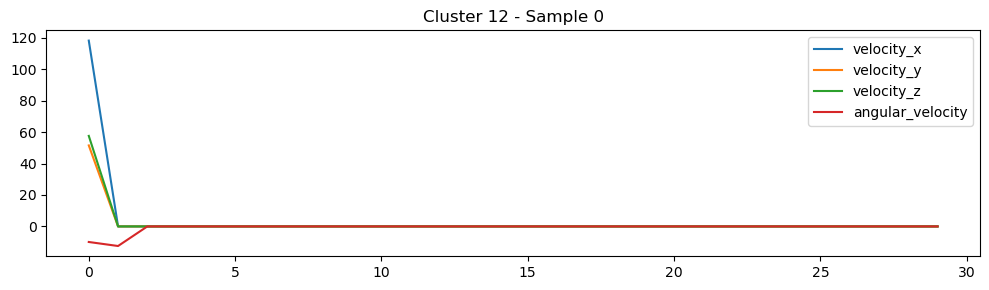

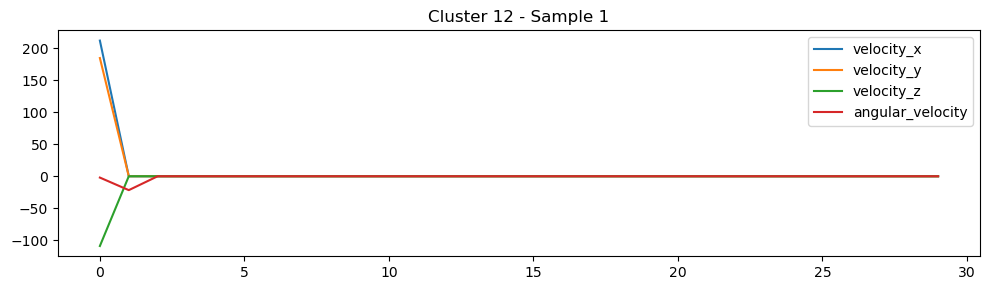

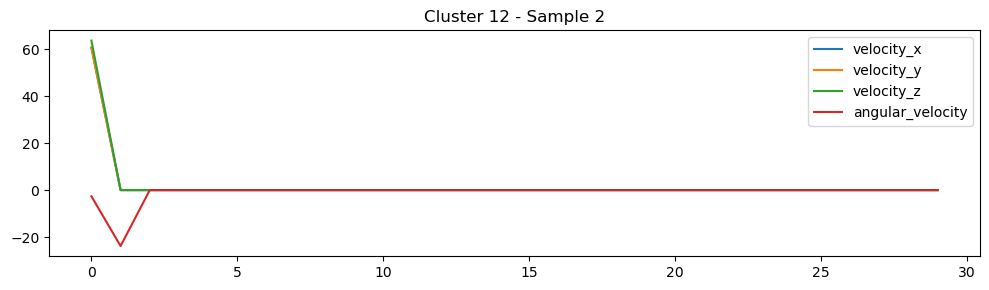

📌 Cluster 13 - 5 samples


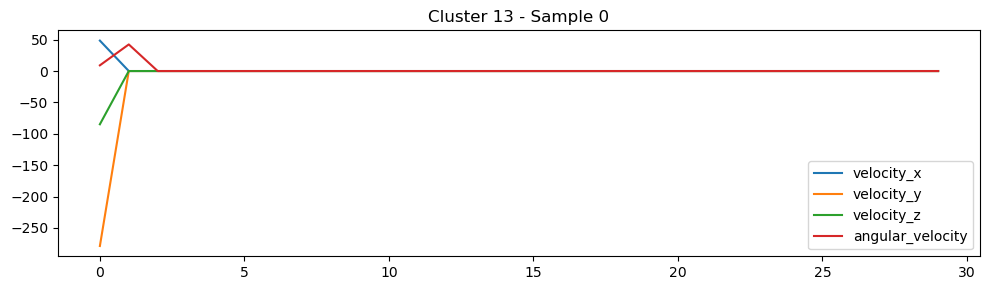

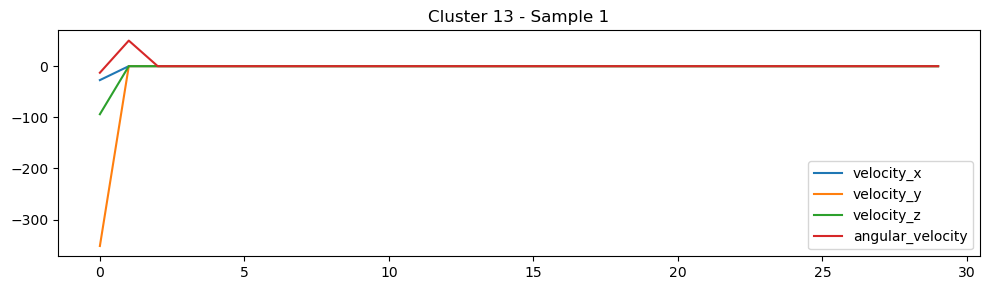

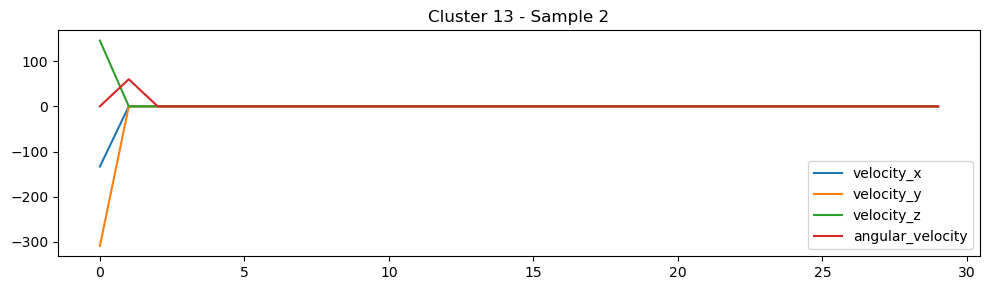

📌 Cluster 14 - 30 samples


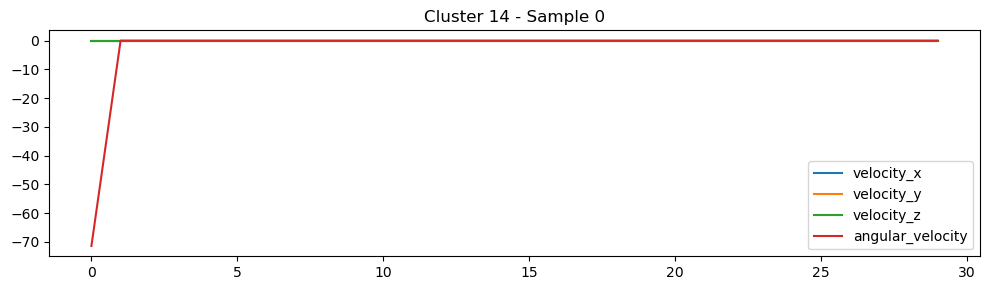

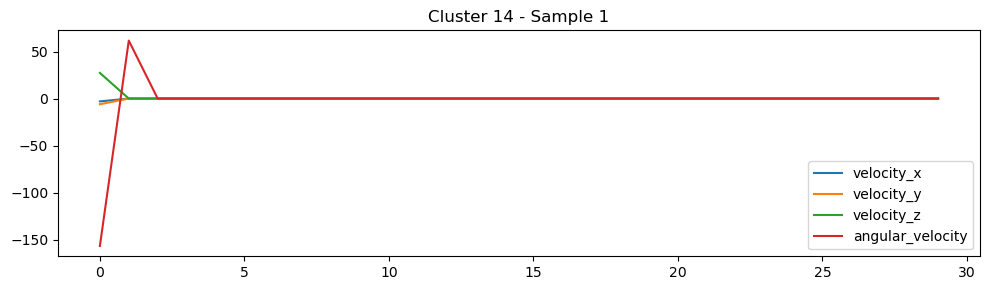

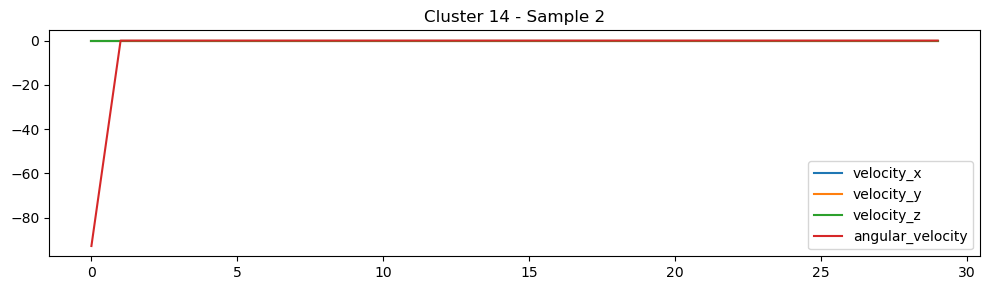

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load filtered data
filtered_samples = np.load('bee_samples_active_only.npy')         # shape: (270, 30, 4)
filtered_labels = np.load('bee_cluster_labels_active_only.npy')           # shape: (270,)

# For organizing
df_filtered = pd.DataFrame({
    'index': range(len(filtered_labels)),
    'cluster': filtered_labels,
    'sample': list(filtered_samples)
})

# Loop over each unique cluster
unique_clusters = np.unique(filtered_labels)

for cluster_id in unique_clusters:
    samples = df_filtered[df_filtered['cluster'] == cluster_id]
    print(f"📌 Cluster {cluster_id} - {len(samples)} samples")

    # Show 3 example plots (or fewer if not enough samples)
    for i in range(min(3, len(samples))):
        sample = samples.iloc[i]['sample']
        plt.figure(figsize=(10, 3))
        plt.plot(sample[:, 0], label='velocity_x')
        plt.plot(sample[:, 1], label='velocity_y')
        plt.plot(sample[:, 2], label='velocity_z')
        plt.plot(sample[:, 3], label='angular_velocity')
        plt.title(f"Cluster {cluster_id} - Sample {i}")
        plt.legend()
        plt.tight_layout()
        plt.show()